In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from google.colab.patches import cv2_imshow
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path = '/content/drive/MyDrive/Final year project 22-23/cleaned_dataset/'
# labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
# annotated_data = '/content/drive/MyDrive/Final year project 22-23/cleaned_annotatation_data.csv'

# for folder in os.listdir(path):
#   folder_path=path+folder
#   for filename in os.listdir(folder_path):
#     if filename.endswith('xml'):
#       info = xet.parse(folder_path+'/'+filename)
#       root = info.getroot()
#       member_object = root.find('object')
#       labels_info = member_object.find('bndbox')
#       xmin = int(labels_info.find('xmin').text)
#       xmax = int(labels_info.find('xmax').text)
#       ymin = int(labels_info.find('ymin').text)
#       ymax = int(labels_info.find('ymax').text)

#       labels_dict['filepath'].append(folder_path+'/'+filename)
#       labels_dict['xmin'].append(xmin)
#       labels_dict['xmax'].append(xmax)
#       labels_dict['ymin'].append(ymin)
#       labels_dict['ymax'].append(ymax)

In [ ]:
# df = pd.DataFrame(labels_dict)
# df.to_csv('labels.csv',index=False)
# df.head(5)

filepath  xmin  xmax  ymin  ymax
0  /content/drive/MyDrive/Kavach 23/image_dataset...   189   333   266   303
1  /content/drive/MyDrive/Kavach 23/image_dataset...   101   242   323   374
2  /content/drive/MyDrive/Kavach 23/image_dataset...   121   244   163   202
3  /content/drive/MyDrive/Kavach 23/image_dataset...   142   316   148   230
4  /content/drive/MyDrive/Kavach 23/image_dataset...   138   348   249   301

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Final year project 22-23/cleaned_annotatation_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
col = df.pop('label')
df.insert(0, 'label', col)
df['filepath']=''
col=df.pop('filepath')
df.insert(0, 'filepath', col)
for i in range(len(df)):
  l=df['label'][i].split('_')
  df['filepath'][i]='/content/drive/MyDrive/Final year project 22-23/cleaned_dataset/'+l[0]+'_thermal/'+df['image'][i]
df

<ipython-input-77-656cf725ed0c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filepath'][i]='/content/drive/MyDrive/Final year project 22-23/cleaned_dataset/'+l[0]+'_thermal/'+df['image'][i]


filepath                label  \
0     /content/drive/MyDrive/Final year project 22-2...          diode_fault   
1     /content/drive/MyDrive/Final year project 22-2...          diode_fault   
2     /content/drive/MyDrive/Final year project 22-2...          diode_fault   
3     /content/drive/MyDrive/Final year project 22-2...          diode_fault   
4     /content/drive/MyDrive/Final year project 22-2...          diode_fault   
...                                                 ...                  ...   
1821  /content/drive/MyDrive/Final year project 22-2...  single_cell_hotspot   
1822  /content/drive/MyDrive/Final year project 22-2...  single_cell_hotspot   
1823  /content/drive/MyDrive/Final year project 22-2...  single_cell_hotspot   
1824  /content/drive/MyDrive/Final year project 22-2...  single_cell_hotspot   
1825  /content/drive/MyDrive/Final year project 22-2...  single_cell_hotspot   

             image        xmin        ymin        xmax        ymax  
0     FLIR0105.jpg    0.392157  129.803922  313.333333  179.607843  
1     FLIR0149.jpg    0.392157  102.352941  303.137255  139.215686  
2     FLIR0149.jpg  292.156863  150.588235  319.215686  167.058823  
3     FLIR0153.jpg   29.019608  128.235294  297.254902  153.333333  
4     FLIR0153.jpg  278.039216  163.137255  312.549020  183.529412  
...            ...         ...         ...         ...         ...  
1821  FLIR1241.jpg  250.000000  169.000000  285.000000  199.000000  
1822  FLIR1243.jpg  126.250000  157.083333  159.583333  201.250000  
1823  FLIR1248.jpg   86.666667  175.000000  119.166667  195.000000  
1824  FLIR1253.jpg  175.000000   71.250000  204.166667   98.750000  
1825  FLIR1258.jpg  165.833333  166.666667  190.416667  185.000000  

[1826 rows x 7 columns]

In [ ]:
i=[df['filepath'][0], [df['label'][0]], df['image'][0], [df['xmin'][0].astype('float')], [df['ymin'][0].astype('float')], [df['xmax'][0].astype('float')], [df['ymax'][0].astype('float')]]
df_new=pd.DataFrame(df.head(0))
df_new.loc[len(df_new)]=i
df_new

filepath          label  \
0  /content/drive/MyDrive/Final year project 22-2...  [diode_fault]   

          image           xmin           ymin           xmax           ymax  
0  FLIR0105.jpg  [0.392156863]  [129.8039216]  [313.3333333]  [179.6078431]

In [ ]:
c=0
for _, i in df.iterrows():
  if c==0:
    c+=1
    continue
  if i['image'] in df_new['image'].values:
    index=df_new[df_new['image']==i['image']].index.values[0]
    df_new['label'][index].append(i['label'])
    df_new['xmin'][index].append(i['xmin'])
    df_new['xmax'][index].append(i['xmax'])
    df_new['ymin'][index].append(i['ymin'])
    df_new['ymax'][index].append(i['ymax'])
  else:
    df_new.loc[len(df_new.index)]=[i['filepath'], [i['label']], i['image'], [i['xmin']],[i['ymin']],[i['xmax']],[i['ymax']]]
df_new

filepath  \
0     /content/drive/MyDrive/Final year project 22-2...   
1     /content/drive/MyDrive/Final year project 22-2...   
2     /content/drive/MyDrive/Final year project 22-2...   
3     /content/drive/MyDrive/Final year project 22-2...   
4     /content/drive/MyDrive/Final year project 22-2...   
...                                                 ...   
1033  /content/drive/MyDrive/Final year project 22-2...   
1034  /content/drive/MyDrive/Final year project 22-2...   
1035  /content/drive/MyDrive/Final year project 22-2...   
1036  /content/drive/MyDrive/Final year project 22-2...   
1037  /content/drive/MyDrive/Final year project 22-2...   

                                           label         image  \
0                                  [diode_fault]  FLIR0105.jpg   
1                     [diode_fault, diode_fault]  FLIR0149.jpg   
2                     [diode_fault, diode_fault]  FLIR0153.jpg   
3        [diode_fault, diode_fault, diode_fault]  FLIR0158.jpg   
4                     [diode_fault, diode_fault]  FLIR0159.jpg   
...                                          ...           ...   
1033  [single_cell_hotspot, single_cell_hotspot]  FLIR1241.jpg   
1034                       [single_cell_hotspot]  FLIR1243.jpg   
1035                       [single_cell_hotspot]  FLIR1248.jpg   
1036                       [single_cell_hotspot]  FLIR1253.jpg   
1037                       [single_cell_hotspot]  FLIR1258.jpg   

                            xmin                                     ymin  \
0                  [0.392156863]                            [129.8039216]   
1     [0.392156863, 292.1568627]               [102.3529412, 150.5882353]   
2     [29.01960784, 278.0392157]               [128.2352941, 163.1372549]   
3        [0.0, 0.0, 278.0392157]  [170.1960784, 170.1960784, 138.8235294]   
4     [0.392156863, 274.1176471]                [182.745098, 151.7647059]   
...                          ...                                      ...   
1033              [135.0, 250.0]                     [159.5833333, 169.0]   
1034                    [126.25]                            [157.0833333]   
1035               [86.66666667]                                  [175.0]   
1036                     [175.0]                                  [71.25]   
1037               [165.8333333]                            [166.6666667]   

                                         xmax  \
0                               [313.3333333]   
1                  [303.1372549, 319.2156863]   
2                   [297.254902, 312.5490196]   
3     [319.6078431, 319.6078431, 307.4509804]   
4                        [320.0, 292.5490196]   
...                                       ...   
1033                     [165.8333333, 285.0]   
1034                            [159.5833333]   
1035                            [119.1666667]   
1036                            [204.1666667]   
1037                            [190.4166667]   

                                         ymax  
0                               [179.6078431]  
1                  [139.2156863, 167.0588235]  
2                  [153.3333333, 183.5294118]  
3     [229.4117647, 229.4117647, 159.6078431]  
4                   [225.0980392, 168.627451]  
...                                       ...  
1033                     [187.0833333, 199.0]  
1034                                 [201.25]  
1035                                  [195.0]  
1036                                  [98.75]  
1037                                  [185.0]  

[1038 rows x 7 columns]

In [ ]:
df_new.to_csv('merged_annotated_data.csv', index=False)

In [ ]:
# filename = df['filepath'][0]
# def getFilename(filename):
#   filename_image = xet.parse(filename).getroot().find('filename').text
#   lf=filename.split('/')
#   lf=lf[:-1]
#   filename='/'.join(lf)
#   filepath_image = os.path.join(filename+'/'+filename_image)
#   return filepath_image
# getFilename(filename)

'/content/drive/MyDrive/Kavach 23/image_dataset/google_images/1438b735-2d21-4879-8ed4-e5fa086e70c8___Maruti-Suzuki-Swift-Dzire-1.jpg.jpeg'

In [ ]:
# image_path = list(df['filepath'].apply(getFilename))
# image_path[:10]

['/content/drive/MyDrive/Kavach 23/image_dataset/google_images/1438b735-2d21-4879-8ed4-e5fa086e70c8___Maruti-Suzuki-Swift-Dzire-1.jpg.jpeg',
 '/content/drive/MyDrive/Kavach 23/image_dataset/google_images/0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6.jpg',
 '/content/drive/MyDrive/Kavach 23/image_dataset/google_images/11832b13-d514-4f1d-967c-d00e76d21e9b___Yellow-Number-Plate-With-Black-Lettering.jpg.jpeg',
 '/content/drive/MyDrive/Kavach 23/image_dataset/google_images/074d85b8-42ec-4d17-9b8e-9e51ae060243___hqdefault.jpg.jpeg',
 '/content/drive/MyDrive/Kavach 23/image_dataset/google_images/10c96324-3452-43e2-aa68-c8ae7d3c1b6e___844874771_1_1080x720_maruti-suzuki-wagon-r-vxi-bs-iii-2014-petrol-.jpg.jpeg',
 '/content/drive/MyDrive/Kavach 23/image_dataset/google_images/175ff546-0679-4cbb-ab03-acfcd96877b7___Maruti_Wagon_R_Rear.jpg.jpeg',
 '/content/drive/MyDrive/Kavach 23/image_dataset/google_images/07064c2c-2aa3-4419-91a4-92916de8e54c___mahin

/content/drive/MyDrive/Final year project 22-23/cleaned_dataset/multi_thermal/FLIR0177.jpg


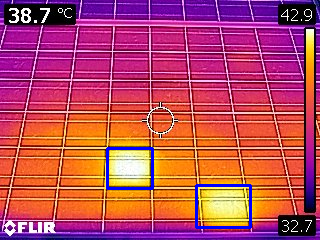

In [ ]:
#DATA VERIFICATION
i=200 #1-diode, 100-dust, 200-multi, 500-pid, 1000-single
file_path = df_new['filepath'][i] #path of our image N2.jpeg
print(file_path)
img = cv2.imread(file_path) #read the image
for j in range(len(df_new['xmin'][i])):
  cmin=int(df_new['xmin'][i][j]), int(df_new['ymin'][i][j])
  cmax=int(df_new['xmax'][i][j]), int(df_new['ymax'][i][j])
  cv2.rectangle(img, cmin, cmax, (255, 0, 0), 2)
cv2_imshow(img)

In [ ]:
df=df_new
df = df.drop(['image'], axis=1)
df['width']=''
df['height']=''
df

filepath  \
0     /content/drive/MyDrive/Final year project 22-2...   
1     /content/drive/MyDrive/Final year project 22-2...   
2     /content/drive/MyDrive/Final year project 22-2...   
3     /content/drive/MyDrive/Final year project 22-2...   
4     /content/drive/MyDrive/Final year project 22-2...   
...                                                 ...   
1033  /content/drive/MyDrive/Final year project 22-2...   
1034  /content/drive/MyDrive/Final year project 22-2...   
1035  /content/drive/MyDrive/Final year project 22-2...   
1036  /content/drive/MyDrive/Final year project 22-2...   
1037  /content/drive/MyDrive/Final year project 22-2...   

                                           label                        xmin  \
0                                  [diode_fault]               [0.392156863]   
1                     [diode_fault, diode_fault]  [0.392156863, 292.1568627]   
2                     [diode_fault, diode_fault]  [29.01960784, 278.0392157]   
3        [diode_fault, diode_fault, diode_fault]     [0.0, 0.0, 278.0392157]   
4                     [diode_fault, diode_fault]  [0.392156863, 274.1176471]   
...                                          ...                         ...   
1033  [single_cell_hotspot, single_cell_hotspot]              [135.0, 250.0]   
1034                       [single_cell_hotspot]                    [126.25]   
1035                       [single_cell_hotspot]               [86.66666667]   
1036                       [single_cell_hotspot]                     [175.0]   
1037                       [single_cell_hotspot]               [165.8333333]   

                                         ymin  \
0                               [129.8039216]   
1                  [102.3529412, 150.5882353]   
2                  [128.2352941, 163.1372549]   
3     [170.1960784, 170.1960784, 138.8235294]   
4                   [182.745098, 151.7647059]   
...                                       ...   
1033                     [159.5833333, 169.0]   
1034                            [157.0833333]   
1035                                  [175.0]   
1036                                  [71.25]   
1037                            [166.6666667]   

                                         xmax  \
0                               [313.3333333]   
1                  [303.1372549, 319.2156863]   
2                   [297.254902, 312.5490196]   
3     [319.6078431, 319.6078431, 307.4509804]   
4                        [320.0, 292.5490196]   
...                                       ...   
1033                     [165.8333333, 285.0]   
1034                            [159.5833333]   
1035                            [119.1666667]   
1036                            [204.1666667]   
1037                            [190.4166667]   

                                         ymax width height  
0                               [179.6078431]               
1                  [139.2156863, 167.0588235]               
2                  [153.3333333, 183.5294118]               
3     [229.4117647, 229.4117647, 159.6078431]               
4                   [225.0980392, 168.627451]               
...                                       ...   ...    ...  
1033                     [187.0833333, 199.0]               
1034                                 [201.25]               
1035                                  [195.0]               
1036                                  [98.75]               
1037                                  [185.0]               

[1038 rows x 8 columns]

In [ ]:
#DATA PROCESSING
labels = df.iloc[:,2:].values
data = []
output = []
for ind in range(len(df)):
    image = df['filepath'][ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    df['height'][ind]=h
    df['width'][ind]=w
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax,x,y = labels[ind]
    label_norm=()
    for i in range(len(xmin)):
      nxmin,nxmax = xmin[i]/w,xmax[i]/w
      nymin,nymax = ymin[i]/h,ymax[i]/h
      label_norm += (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
# Convert data to array
# X = np.array(data,dtype=np.float32)
# y = np.array(output,dtype=np.float32)

In [ ]:
# # Split the data into training and testing set using sklearn.
# x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=0)
# x_train.shape,x_test.shape,y_train.shape,y_test.shape

In [ ]:
# parsing
# def parsing(path):
#     parser = xet.parse(path).getroot()
#     name = parser.find('filepath').text
#     filename = path

#     # width and height
#     parser_size = parser.find('size')
#     width = int(parser_size.find('width').text)
#     height = int(parser_size.find('height').text)

#     return filepath, width, height
# df[['filepath','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
# df.head()

In [ ]:
df['center_x']=''
df['center_y']=''
df['bb_width']=''
df['bb_height']=''

In [ ]:
# df['center_x'] = [[((df['xmax'][x] + df['xmin'][x])/(2*df['width'])) for x in range(len(df['xmin'][i]))] for i in range(len(df))]
# df['center_y'] = [lambda x: (df['ymax'][x] + df['ymin'][x])/(2*df['height']) for x in range(len(xmin))]

# df['bb_width'] = [lambda x: (df['xmax'][x] + df['xmin'][x])/(df['width']) for x in range(len(xmin))]
# df['bb_height'] = [lambda x: (df['ymax'][x] + df['ymin'][x])/(df['height']) for x in range(len(xmin))]

for i in range(len(df)):
  cx=[]
  cy=[]
  bw=[]
  bh=[]
  for x in range(len(df['xmin'][i])):
    cx.append((df['xmax'][i][x] + df['xmin'][i][x])/(2*df['width'][i]))
    cy.append((df['ymax'][i][x] + df['ymin'][i][x])/(2*df['height'][i]))
    bw.append((df['xmax'][i][x] + df['xmin'][i][x])/df['width'][i])
    bh.append((df['ymax'][i][x] + df['ymin'][i][x])/df['height'][i])
  df['center_x'][i]=cx
  df['center_y'][i]=cy
  df['bb_width'][i]=bw
  df['bb_height'][i]=bh
df

filepath  \
0     /content/drive/MyDrive/Final year project 22-2...   
1     /content/drive/MyDrive/Final year project 22-2...   
2     /content/drive/MyDrive/Final year project 22-2...   
3     /content/drive/MyDrive/Final year project 22-2...   
4     /content/drive/MyDrive/Final year project 22-2...   
...                                                 ...   
1033  /content/drive/MyDrive/Final year project 22-2...   
1034  /content/drive/MyDrive/Final year project 22-2...   
1035  /content/drive/MyDrive/Final year project 22-2...   
1036  /content/drive/MyDrive/Final year project 22-2...   
1037  /content/drive/MyDrive/Final year project 22-2...   

                                           label                        xmin  \
0                                  [diode_fault]               [0.392156863]   
1                     [diode_fault, diode_fault]  [0.392156863, 292.1568627]   
2                     [diode_fault, diode_fault]  [29.01960784, 278.0392157]   
3        [diode_fault, diode_fault, diode_fault]     [0.0, 0.0, 278.0392157]   
4                     [diode_fault, diode_fault]  [0.392156863, 274.1176471]   
...                                          ...                         ...   
1033  [single_cell_hotspot, single_cell_hotspot]              [135.0, 250.0]   
1034                       [single_cell_hotspot]                    [126.25]   
1035                       [single_cell_hotspot]               [86.66666667]   
1036                       [single_cell_hotspot]                     [175.0]   
1037                       [single_cell_hotspot]               [165.8333333]   

                                         ymin  \
0                               [129.8039216]   
1                  [102.3529412, 150.5882353]   
2                  [128.2352941, 163.1372549]   
3     [170.1960784, 170.1960784, 138.8235294]   
4                   [182.745098, 151.7647059]   
...                                       ...   
1033                     [159.5833333, 169.0]   
1034                            [157.0833333]   
1035                                  [175.0]   
1036                                  [71.25]   
1037                            [166.6666667]   

                                         xmax  \
0                               [313.3333333]   
1                  [303.1372549, 319.2156863]   
2                   [297.254902, 312.5490196]   
3     [319.6078431, 319.6078431, 307.4509804]   
4                        [320.0, 292.5490196]   
...                                       ...   
1033                     [165.8333333, 285.0]   
1034                            [159.5833333]   
1035                            [119.1666667]   
1036                            [204.1666667]   
1037                            [190.4166667]   

                                         ymax width height  \
0                               [179.6078431]   320    240   
1                  [139.2156863, 167.0588235]   320    240   
2                  [153.3333333, 183.5294118]   320    240   
3     [229.4117647, 229.4117647, 159.6078431]   320    240   
4                   [225.0980392, 168.627451]   320    240   
...                                       ...   ...    ...   
1033                     [187.0833333, 199.0]   320    240   
1034                                 [201.25]   320    240   
1035                                  [195.0]   320    240   
1036                                  [98.75]   320    240   
1037                                  [185.0]   320    240   

                                               center_x  \
0                                 [0.49019607837968754]   
1             [0.47426470587968755, 0.9552696078124999]   
2                    [0.509803921625, 0.92279411765625]   
3     [0.49938725484375, 0.49938725484375, 0.9148284...   
4                [0.5006127450984376, 0.88541666671875]   
...                                                 ...   
1033                      [0.470052083281

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15578, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 15578 (delta 81), reused 114 (delta 58), pack-reused 15393
Receiving objects: 100% (15578/15578), 14.64 MiB | 22.58 MiB/s, done.
Resolving deltas: 100% (10605/10605), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
mkdir /content/yolov5/data_images

In [ ]:
mkdir /content/yolov5/data_images/test/

In [ ]:
mkdir /content/yolov5/data_images/train/

In [ ]:
### split the data into train and test
df_train = df.iloc[:int(len(df)*.75)]
df_test = df.iloc[int(len(df)*.75):]
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_folder = './yolov5/data_images/train'

values = df_train[['filepath','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filepath','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

In [ ]:
import yaml
yaml_dict = {'train': 'data_images/train',   # path to the train folder
            'val': 'data_images/test', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['liscence_plate']}                # list of label names

with open(r'./yolov5/data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [ ]:
!nvidia-smi

Sun Apr 23 10:38:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=885b6711d34e939243f14cb3f0c0ffdc4b587f9b1b98c5d57c7abea0eca32e55
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built GPUtil


In [ ]:


import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  3% |  1% |


In [ ]:
!python ./yolov5/train.py --data ./yolov5/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100 --imgsz 320

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./yolov5/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-151-g3e14883 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=

In [ ]:
# import onnx
# from onnx import utils

# model = onnx.load('model.onnx')
# model = utils.backward_compatible(model, target_version=11)
# onnx.save(model, 'model_v11.onnx')


In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.6 MB)

TorchScript: starting export with torch 2.0.0+cu118...
TorchScript: export success ✅ 4.8s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.13.1...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
==========

In [ ]:
!python ./yolov5/export.py --weights ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx --opset 11


export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=11, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.6 MB)

TorchScript: starting export with torch 2.0.0+cu118...
TorchScript: export success ✅ 2.6s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.13.1...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
==========

In [ ]:
#predictions

INPUT_WIDTH =  640
INPUT_HEIGHT = 640


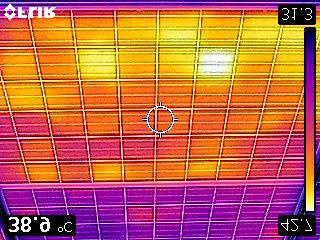

In [ ]:
# LOAD THE IMAGE
img = io.imread('/content/drive/MyDrive/Final year project 22-23/augmented_dataset/PID_thermal/FLIR0182_v.jpg')

fig = px.imshow(img)
fig.update_layout(width=400, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_supression(input_image,detections):

    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE

    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)

    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    texts = []
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])
        texts.append(license_text)


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image, texts

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img, texts = drawings(img,boxes_np,confidences_np,index)
    return result_img, texts

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.2/608.2 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72


In [ ]:
import easyocr

# initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]

    if 0 in roi.shape:
        return 'no number'

    else:
        # extract text using EasyOCR
        result = reader.readtext(roi)
        text = ' '.join([res[1] for res in result])
        text = text.strip()

        return text


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# test
from PIL import Image
img = Image.open('/content/drive/MyDrive/Final year project 22-23/augmented_dataset/single_thermal/FLIR0014.jpg')

import numpy as np
img = np.array(img)

results, texts = yolo_predictions(img, net)
texts


[]


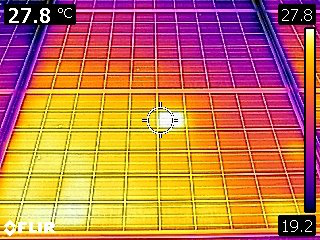

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [ ]:
!pip install libgtk2.0-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement libgtk2.0-dev (from versions: none)
ERROR: No matching distribution found for libgtk2.0-dev


[]


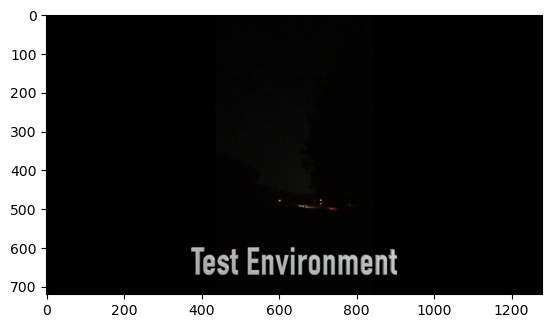

[]


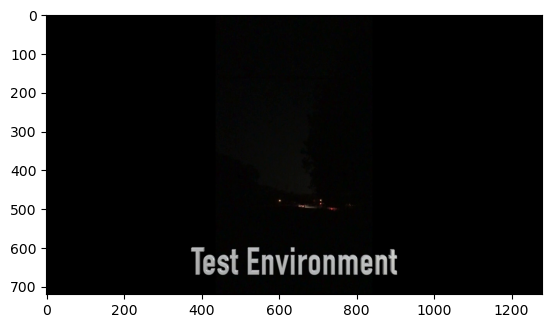

[]


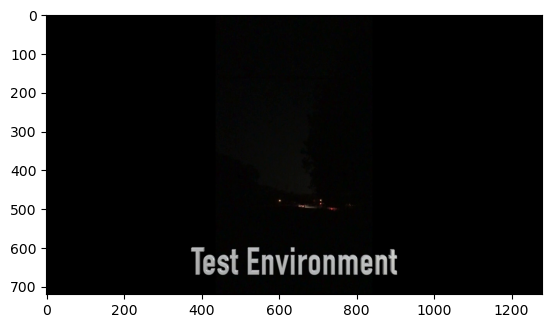

[]


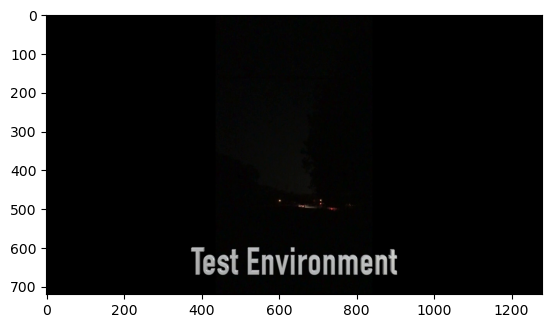

[]


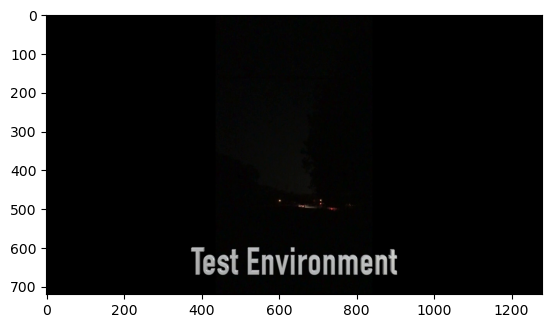

[]


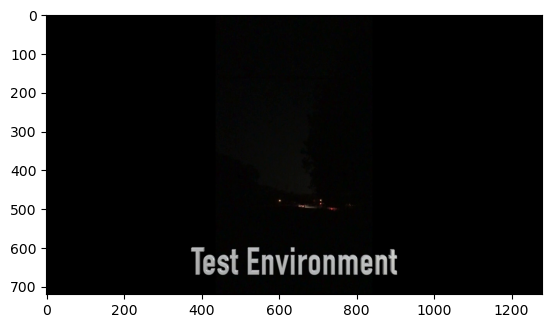

[]


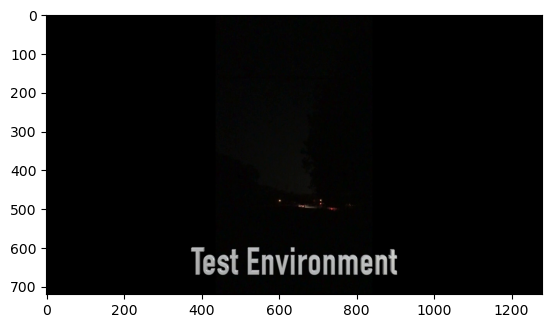

[]


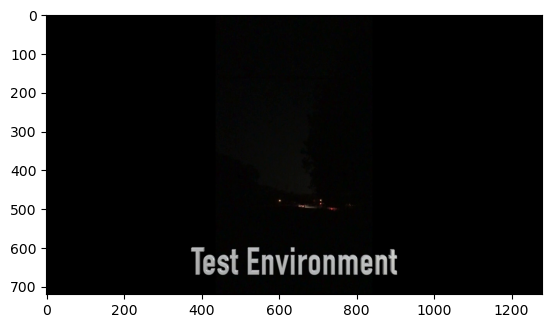

[]


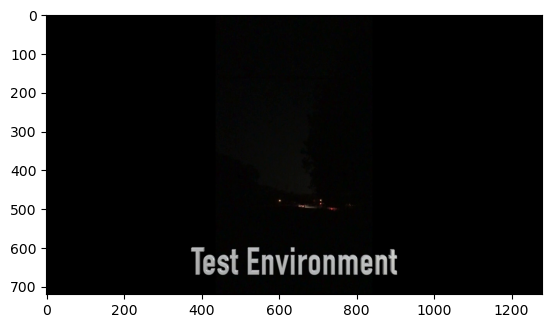

[]


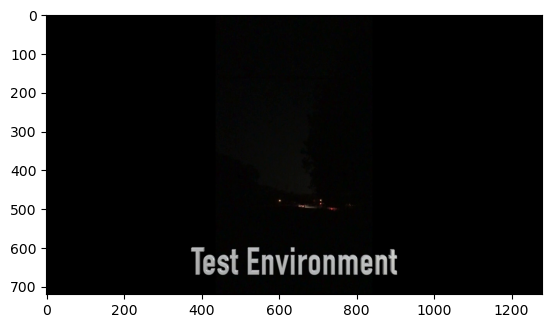

[]


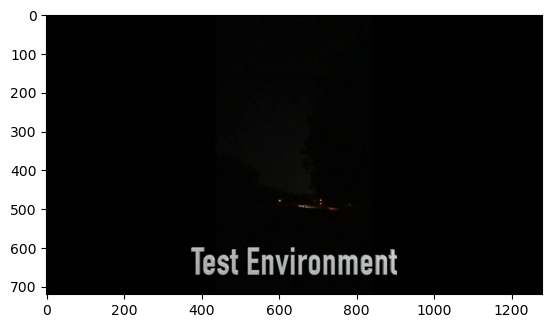

[]


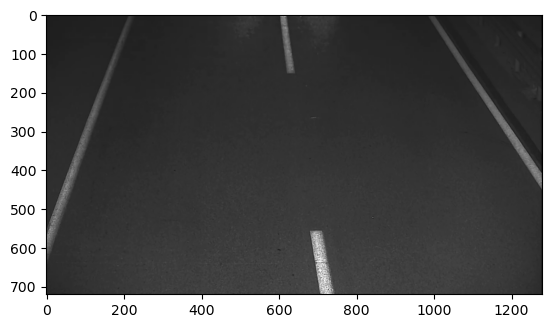

[]


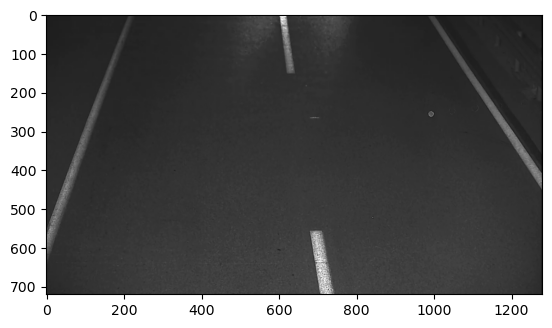

[]


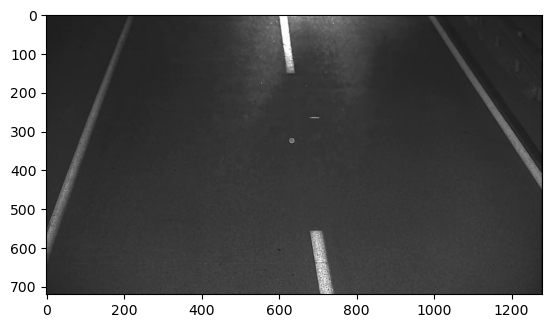

[]


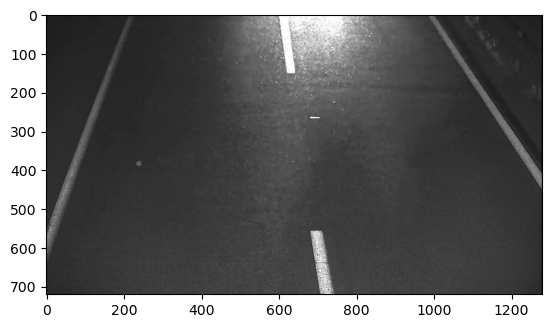

[]


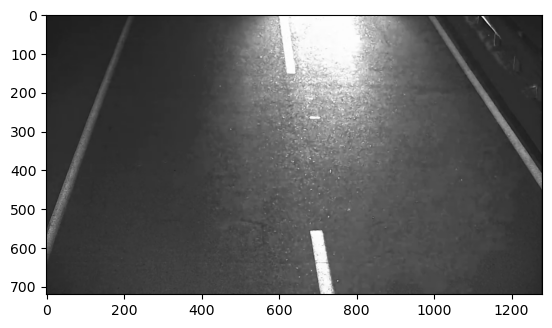

[]


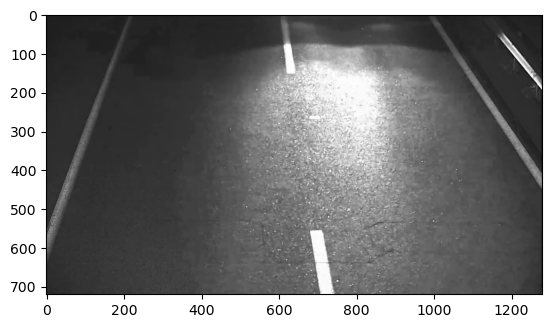

[]


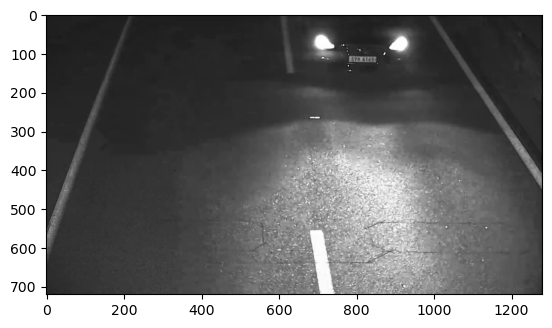

['L590 6165.']


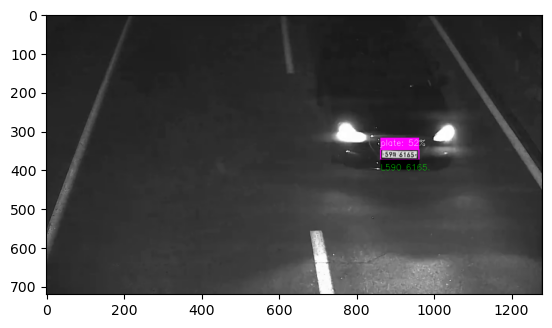

['590 6165,']


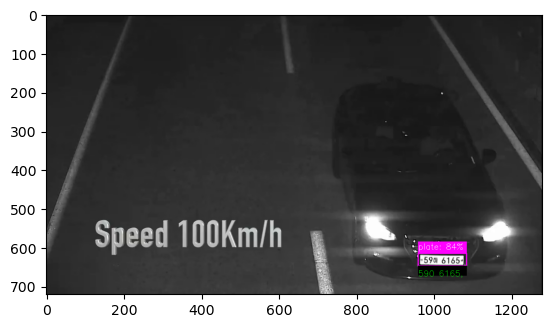

['590 6165-']


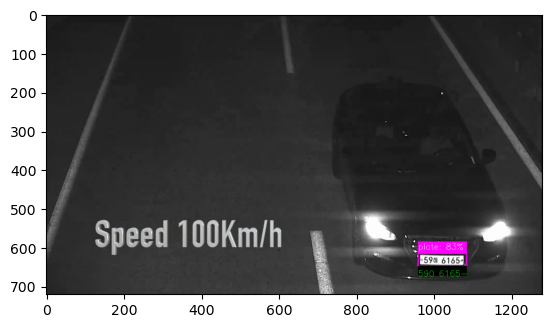

['590 6165-']


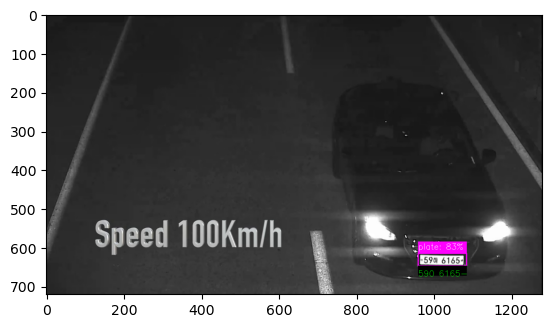

['590 6165-']


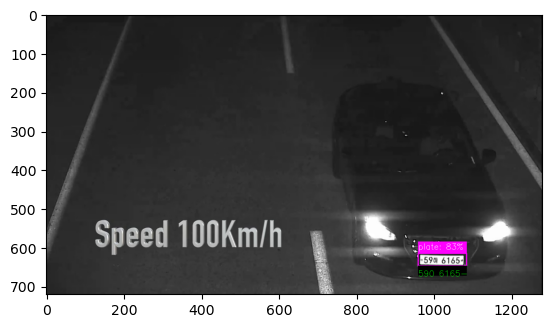

['590 6165-']


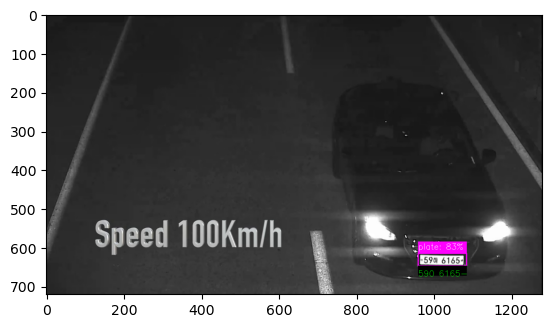

['590 6165-']


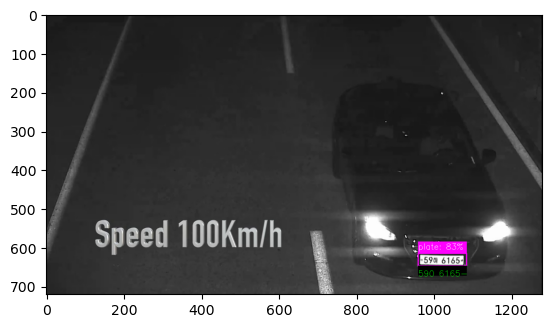

['590 6165-']


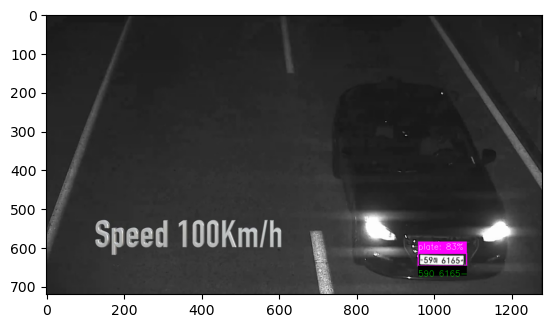

['590 6165-']


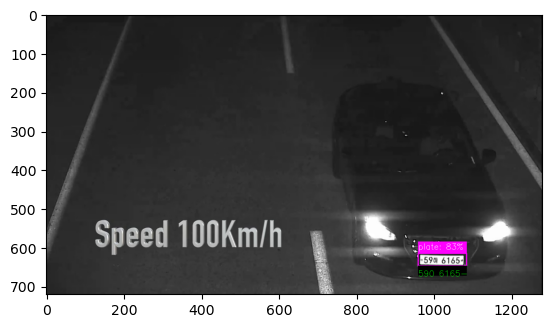

['590 6165-']


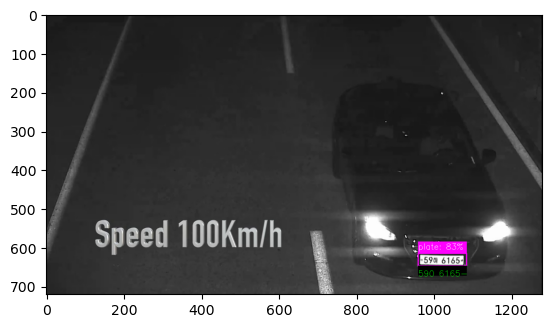

['590 6165-']


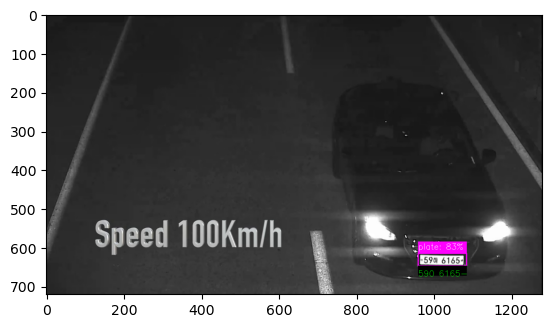

['590 6165-']


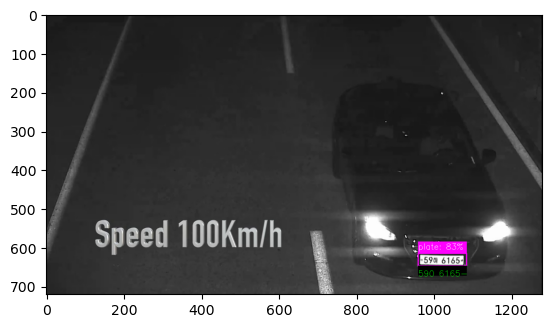

['590 6165,']


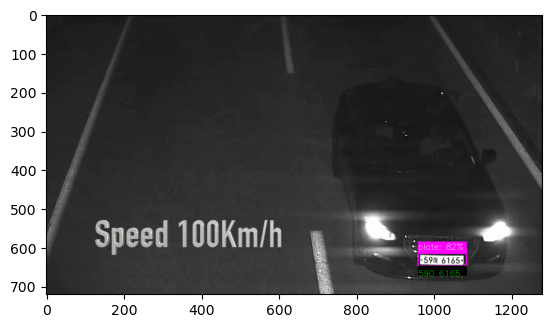

['590 6165,']


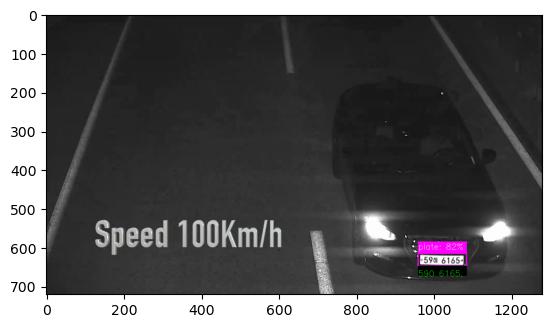

['590 6165,']


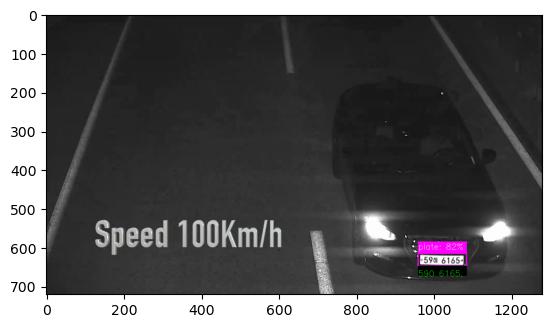

['590 6165,']


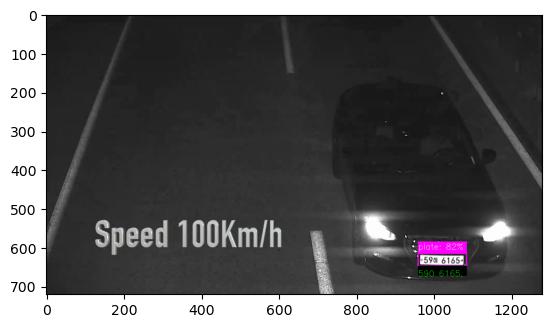

[]


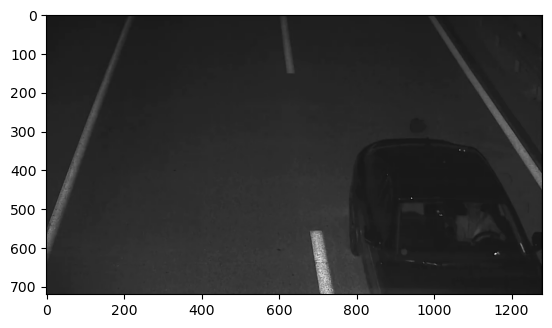

[]


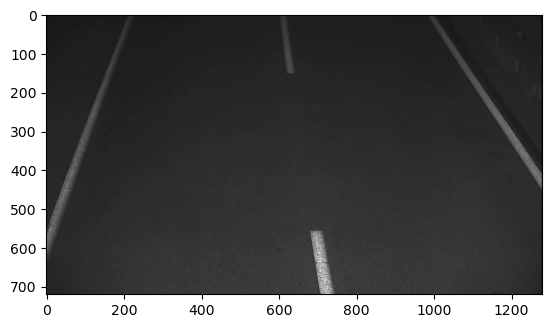

[]


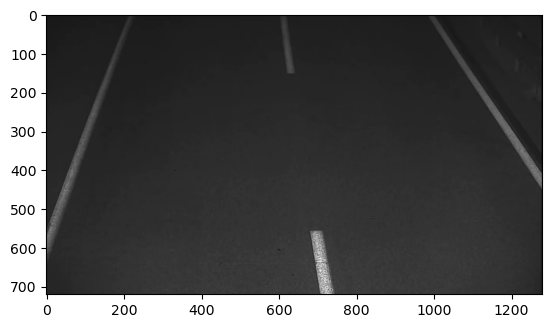

[]


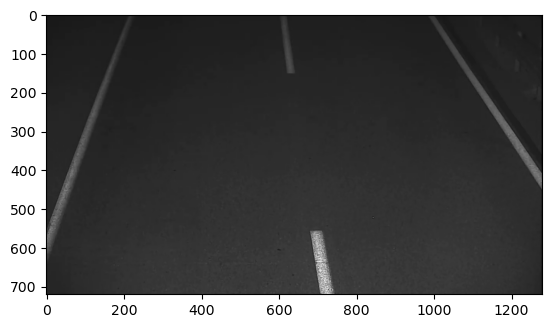

[]


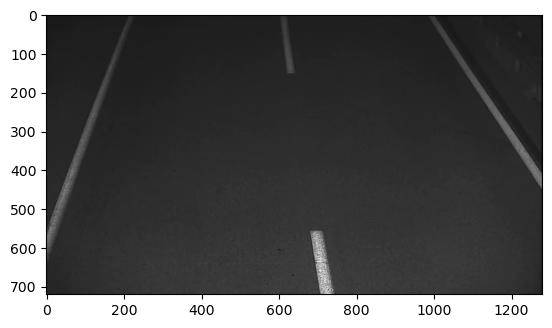

[]


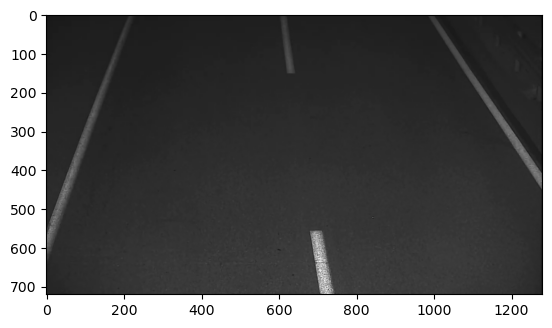

[]


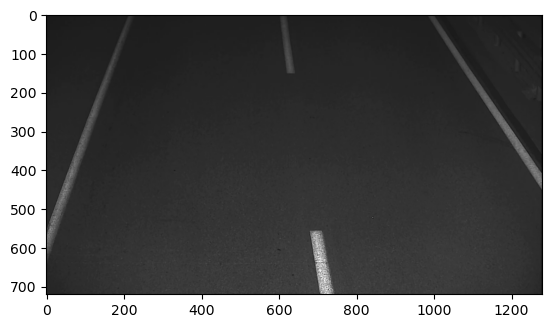

[]


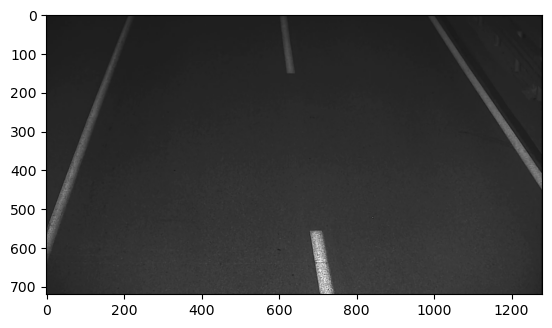

[]


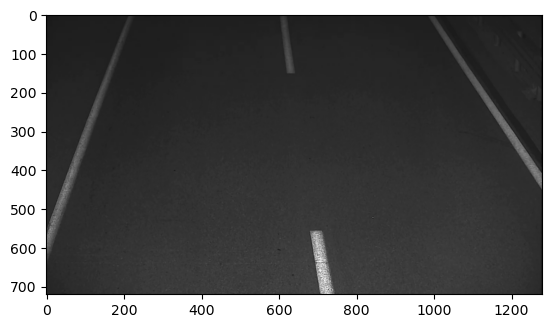

[]


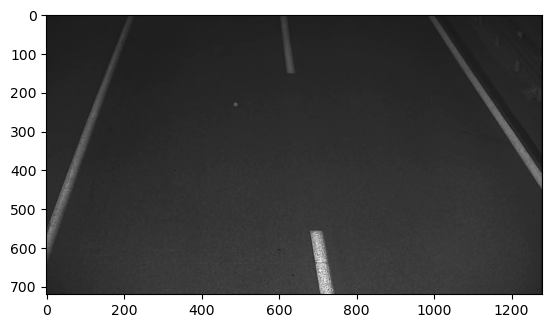

[]


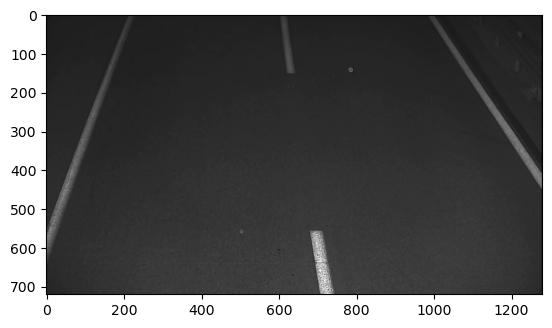

[]


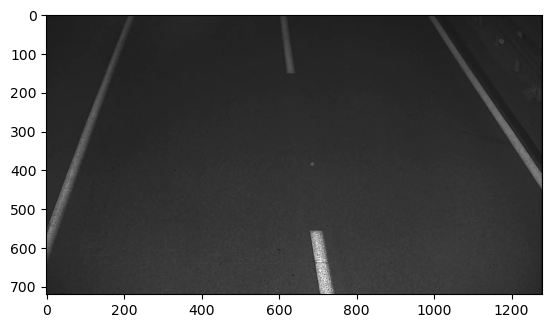

[]


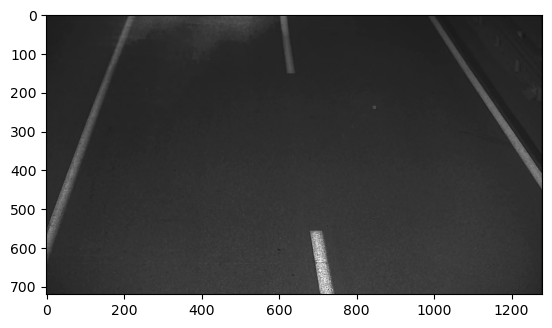

[]


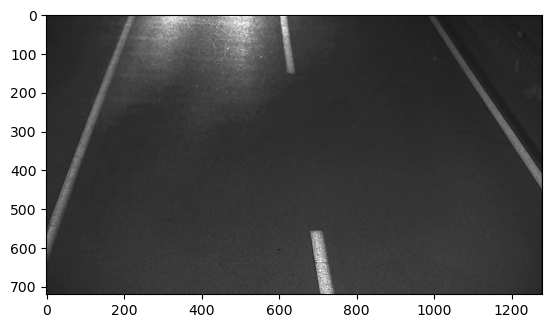

[]


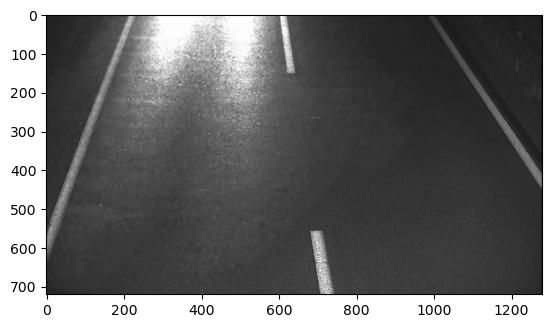

[]


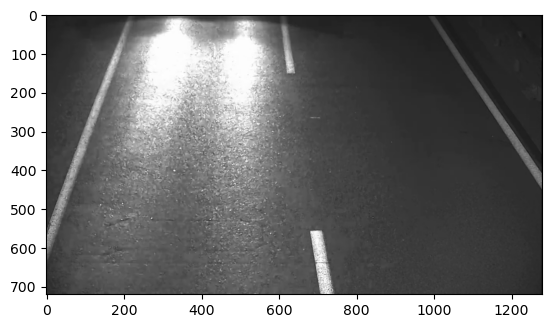

[]


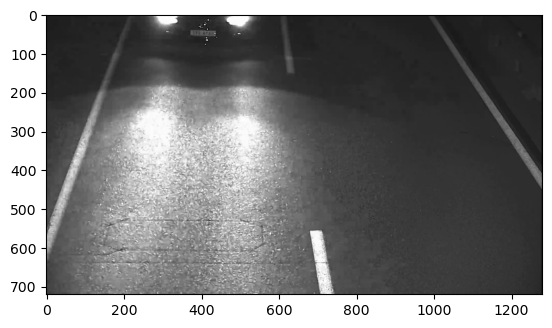

[]


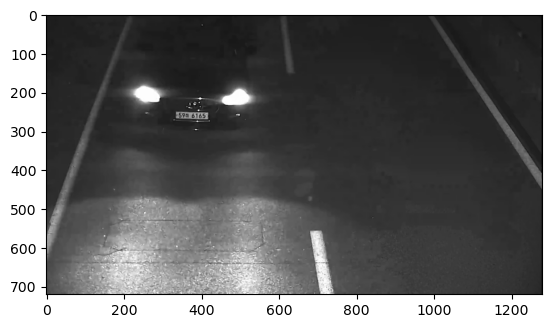

['590 61659']


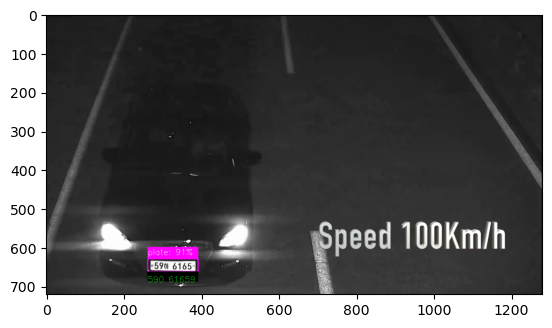

['590 61659']


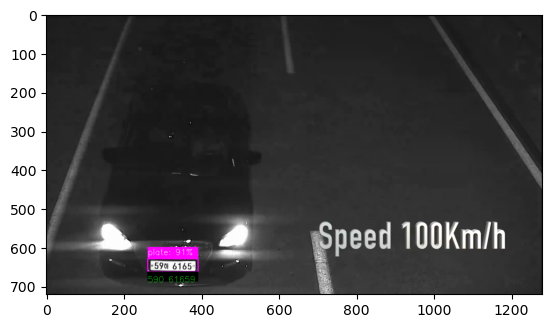

['590 61659']


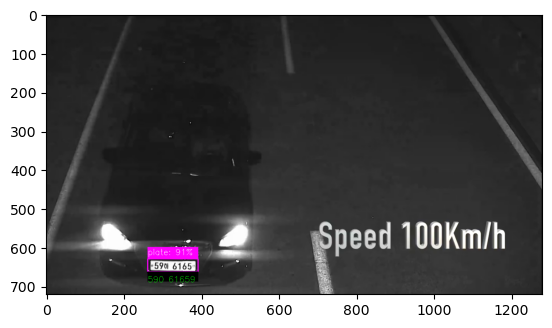

['590 61659']


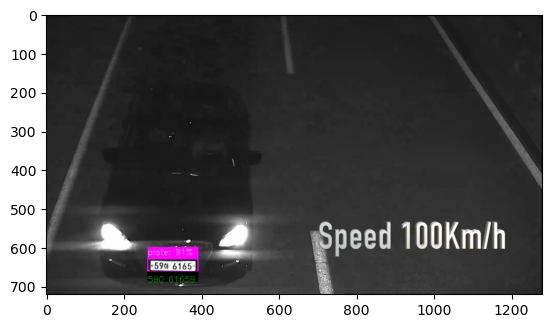

['590 61659']


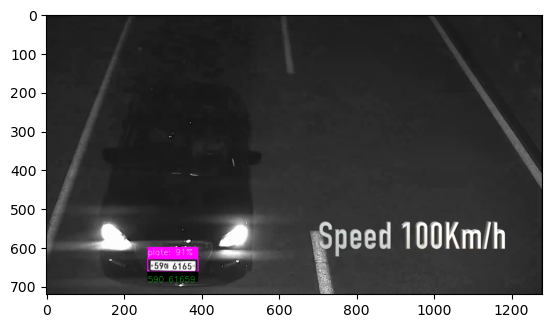

['590 61659']


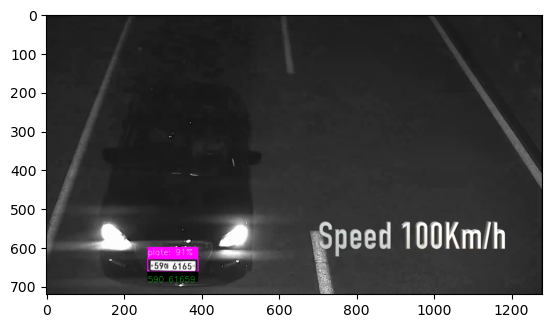

['590 61659']


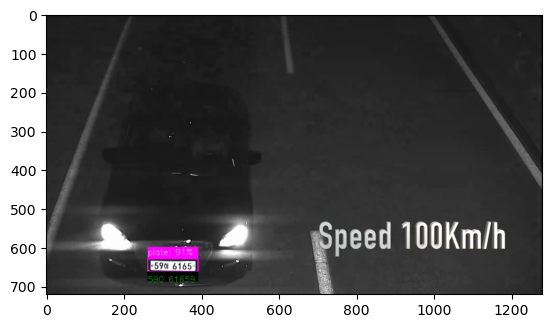

['590 61659']


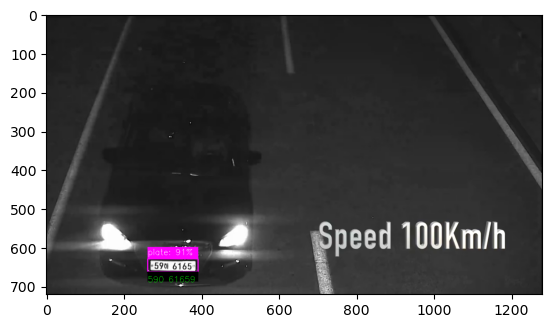

['590 61659']


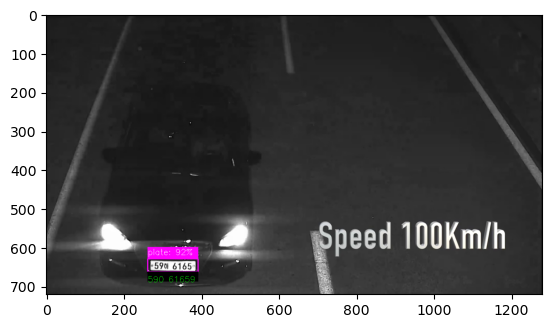

['590 61659']


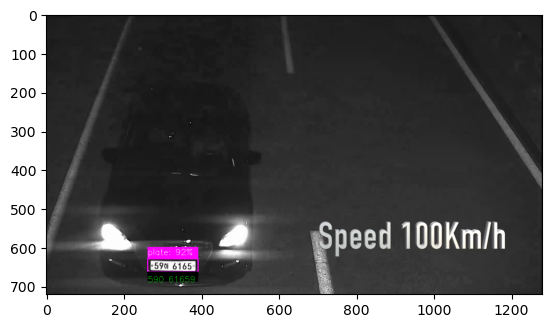

['590 61659']


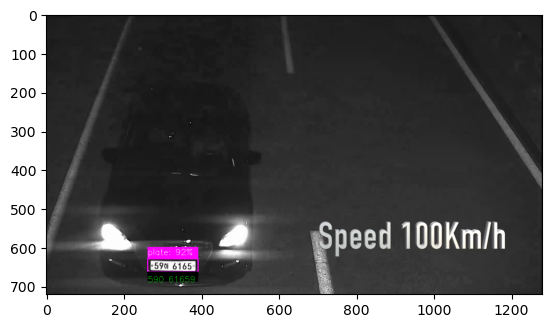

['590 61659']


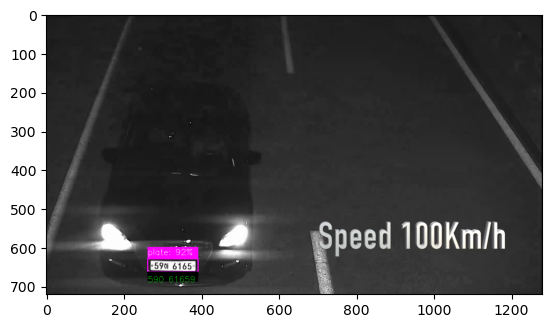

['590 61659']


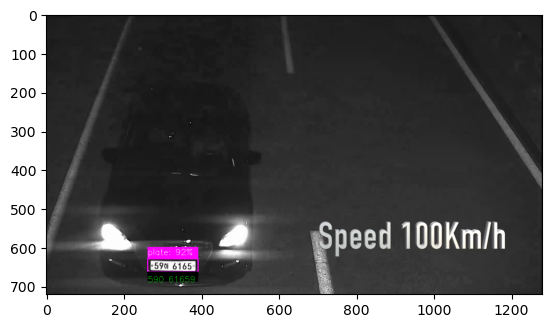

['590 61659']


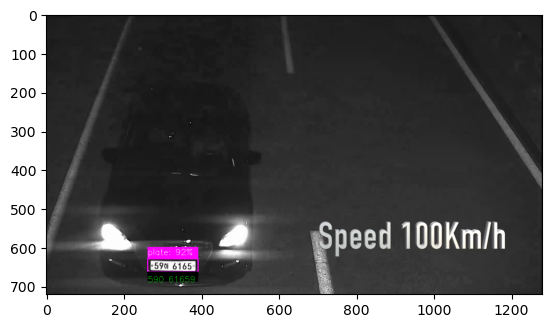

['590 61659']


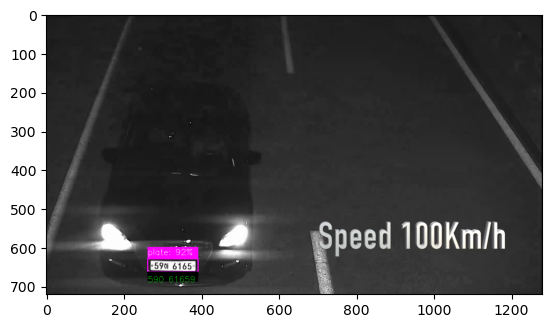

[]


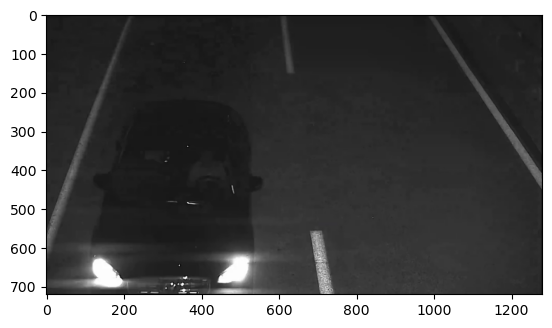

[]


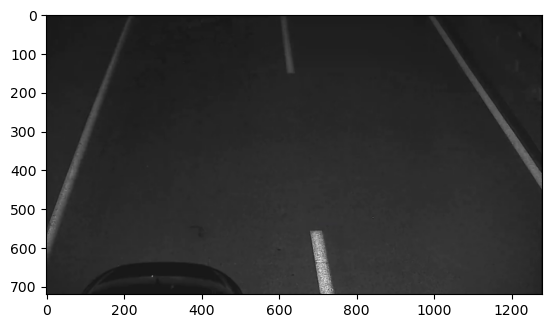

[]


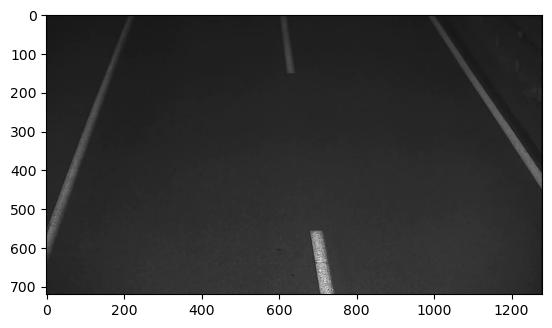

[]


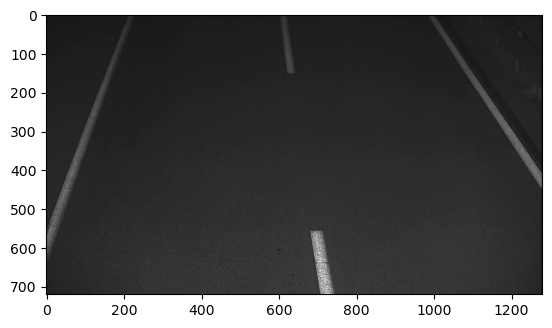

[]


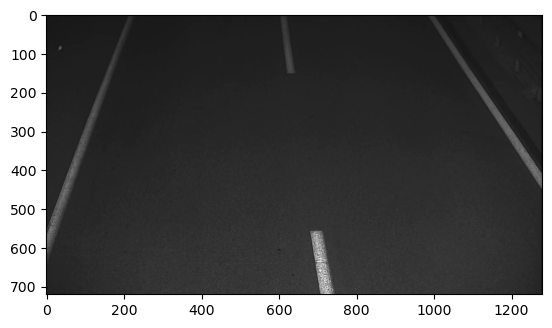

[]


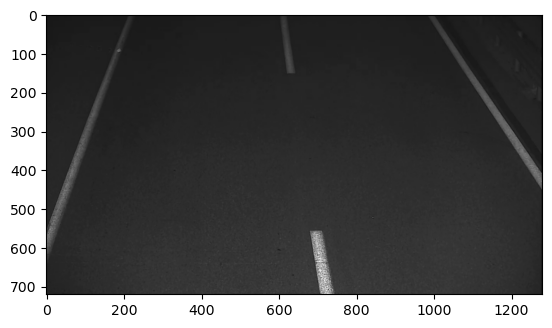

[]


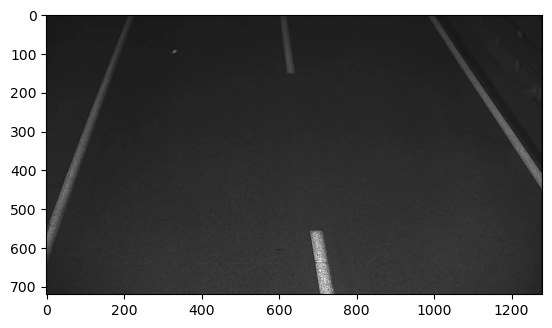

[]


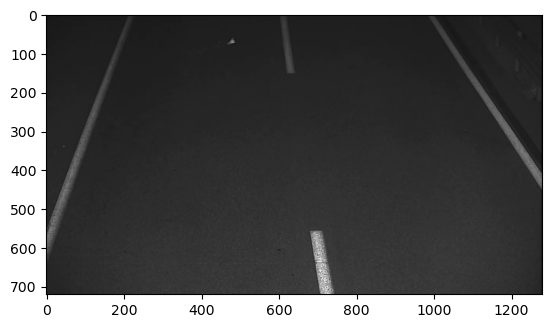

Unable to read video


error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/highgui/src/window.cpp:1268: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

cap = cv2.VideoCapture('/kaggle/input/testing/anprTest.mp4')
text_results = []
while cap.isOpened():
    ret, frame = cap.read()

    if ret == False:
        print('Unable to read video')
        break

    for i in range(5):
            ret = cap.grab()

    results, texts = yolo_predictions(frame,net)
    text_results.append(texts)
    print(texts)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()
#     if cv2.waitKey(30) == 27 :
#         break
#     if cv2.waitKey(1) == ord('q'):
#             break

cv2.destroyAllWindows()
cap.release()

